In [4]:
from dataloader import DataLoader
loader = DataLoader()

df = loader.get_data()

_initialize_data took 77.8110 seconds


#### Outlier Detection

In [5]:
import polars as pl
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

###################################################
# Parameters
###################################################
start_year = 2015  # We start evaluating anomalies from this year onwards
edge_feature_cols = [
    "tradeflow_baci", 
    "diplo_disagreement", 
    "q", 
    "v", 
    "comrelig", 
    "distw_harmonic", 
    "pop_o", 
    "pop_d",
    "wto_o", 
    "wto_d", 
    "eu_o", 
    "eu_d", 
    "entry_cost_o", 
    "entry_cost_d"
]
n_folds = 5
epochs = 100
lr = 0.01

adj_loss_weight = 0.5
attr_loss_weight = 0.5

# DEVICE
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

/Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch_cluster/_grid_cpu.so, 0x0006): Symbol not found: __ZN3c106SymInt19promote_to_negativeEv
  Referenced from: <6A93553B-44A9-30CE-B8A9-28BC9FFE9203> /Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch_cluster/_grid_cpu.so
  Expected in:     <3F9923D2-81A5-3EC8-9739-EC0C1C816132> /Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/Users/kevinbrundler/Documents/HS24/Network Science/UZH-Network-Science/.venv2/lib/python3.10/site-pack

Using device: mps


In [6]:
###################################################
# Helper Functions
###################################################
def prepare_graph_data(pdf, all_countries, edge_feature_cols, scaler=None):
    """
    Convert a filtered pandas DataFrame into a PyTorch Geometric Data object.

    Parameters
    ----------
    pdf : pd.DataFrame
        Filtered DataFrame for a given product-year subset.
    all_countries : np.ndarray
        Array of all unique country codes encountered.
    edge_feature_cols : list of str
        List of edge feature column names.
    scaler : StandardScaler, optional
        A fitted scaler to transform edge features. If None, no scaling is applied.

    Returns
    -------
    (edge_index, edge_attr) : (torch.Tensor, torch.Tensor)
        edge_index: shape [2, num_edges], edge_attr: shape [num_edges, num_features]
    """
    country_to_id = {c: i for i, c in enumerate(all_countries)}
    
    def map_countries(series):
        return series.map(country_to_id)
    
    src = map_countries(pdf['export_country'])
    dst = map_countries(pdf['import_country'])
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)
    
    for col in edge_feature_cols:
        pdf[col] = pdf[col].fillna(0.0).astype(float)
        
    edge_attr_values = pdf[edge_feature_cols].values
    if scaler is not None:
        edge_attr_values = scaler.transform(edge_attr_values)
    edge_attr = torch.tensor(edge_attr_values, dtype=torch.float)
    return edge_index, edge_attr

In [7]:
###################################################
# Graph Network
###################################################
class GCNEncoder(nn.Module):
    """
    GCN-based encoder to produce node embeddings.
    """
    def __init__(self, in_channels, out_channels=32):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(nn.Module):
    """
    Decoder that predicts edge existence (edge_prob) and only the 'v' attribute from node embeddings.
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.adj_bias = nn.Parameter(torch.zeros(1))
        self.mlp = nn.Sequential(
            nn.Linear(2 * emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, z, edge_index):
        u = edge_index[0]
        v = edge_index[1]
        z_u = z[u]
        z_v = z[v]
        
        ################################
        # Edge existence probability
        ################################
        scores = (z_u * z_v).sum(dim=-1) + self.adj_bias
        edge_prob = torch.sigmoid(scores)

        ################################
        # Prediction of the volume (v)
        ################################
        edge_input = torch.cat([z_u, z_v], dim=-1)
        v_pred = self.mlp(edge_input).squeeze(-1)

        return edge_prob, v_pred


class GAEModel(nn.Module):
    """
    Graph Autoencoder model combining GCNEncoder and EdgeDecoder.
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    
    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    
    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decoder(z, edge_index)


    def recon_loss(self, z, edge_index, edge_attr, v_index):
        """
        Compute reconstruction loss: sum of adjacency (BCE) and MSE loss for 'v' only.

        Parameters
        ----------
        z : torch.Tensor
            Node embeddings.
        edge_index : torch.Tensor
            Edge indices.
        edge_attr : torch.Tensor
            Original edge attributes.
        v_index : int
            The column index of 'v' in the edge attributes array.
        """
        edge_prob, v_pred = self.decoder(z, edge_index)

        adj_loss = F.binary_cross_entropy(edge_prob, torch.ones_like(edge_prob))

        v_true = edge_attr[:, v_index]
        v_loss = F.mse_loss(v_pred, v_true)

        return adj_loss + v_loss
    
    
    def recon_loss_with_neg(self, z, pos_edge_index, neg_edge_index, pos_edge_attr, v_index, adj_weight=0.5, attr_weight=0.5):
        """
        Compute the reconstruction loss for the GAE model using both positive and negative samples.
    
        This method calculates two types of losses:
        1. Adjacency Reconstruction Loss (Binary Cross-Entropy):
           - Positive edges (pos_edge_index) are expected to exist, so their target is 1.
           - Negative edges (neg_edge_index) are sampled non-existing edges, so their target is 0.
           The final adjacency loss is the average of positive and negative edge losses.
    
        2. Attribute Reconstruction Loss (Mean Squared Error for 'v'):
           - Computed only for positive edges, comparing the predicted 'v' values to the true values.
           - 'v' is identified by the column index v_index in pos_edge_attr.
    
        The final loss is a weighted combination of the adjacency and attribute losses.
    
        Parameters
        ----------
        z : torch.Tensor
            Node embeddings of shape [num_nodes, embedding_dim].
        pos_edge_index : torch.Tensor
            Edge indices for positive (observed) edges, of shape [2, num_positive_edges].
        neg_edge_index : torch.Tensor
            Edge indices for negative (non-observed) edges, of shape [2, num_negative_edges].
        pos_edge_attr : torch.Tensor
            Attributes of the positive edges, shape [num_positive_edges, num_edge_features].
        v_index : int
            Column index of 'v' in pos_edge_attr, indicating which attribute represents the volume.
        adj_weight : float, optional (default=0.5)
            Weight assigned to the adjacency reconstruction loss.
        attr_weight : float, optional (default=0.5)
            Weight assigned to the attribute reconstruction loss.
    
        Returns
        -------
        torch.Tensor
            A scalar loss value (float) representing the weighted sum of adjacency and attribute reconstruction losses.
        """
        pos_edge_prob, pos_v_pred = self.decoder(z, pos_edge_index)
        neg_edge_prob, _ = self.decoder(z, neg_edge_index)
    
        pos_adj_loss = F.binary_cross_entropy(pos_edge_prob, torch.ones_like(pos_edge_prob))
        neg_adj_loss = F.binary_cross_entropy(neg_edge_prob, torch.zeros_like(neg_edge_prob))
        adj_loss = (pos_adj_loss + neg_adj_loss) / 2.0
    
        v_true = pos_edge_attr[:, v_index]
        v_loss = F.mse_loss(pos_v_pred, v_true)
    
        return adj_weight * adj_loss + attr_weight * v_loss


def train_model(model, data, v_index, epochs=100, lr=0.01, device=torch.device("cpu"), adj_weight=0.5, attr_weight=0.5):
    """
    Train the GAE model on given data, focusing only on 'v' reconstruction.

    Parameters
    ----------
    model : GAEModel
        The GAE model to train.
    data : torch_geometric.data.Data
        Graph data including x, edge_index, edge_attr.
    v_index : int
        Index of 'v' in data.edge_attr.
    epochs : int
        Number of training epochs.
    lr : float
        Learning rate.
    device : torch.device
        Device to run computations on (CPU or GPU).

    Returns
    -------
    None
    """
    model.to(device)
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.edge_attr = data.edge_attr.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        
        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.x.size(0),
            num_neg_samples=data.edge_index.size(1)
        ).to(device)

        loss = model.recon_loss_with_neg(
            z, 
            data.edge_index, 
            neg_edge_index, 
            data.edge_attr, 
            v_index, 
            adj_weight=adj_weight, 
            attr_weight=attr_weight
        )
        loss.backward()
        optimizer.step()
        


def compute_anomaly_scores(model, data, v_index, device=torch.device("cpu")):
    """
    Compute anomaly scores (reconstruction error) for each edge.

    Parameters
    ----------
    model : GAEModel
        Trained GAE model.
    data : torch_geometric.data.Data
        Graph data including x, edge_index, edge_attr.
    v_index : int
        Index of 'v' in data.edge_attr.
    device : torch.device
        Device to run computations on (CPU or GPU).

    Returns
    -------
    anomaly_scores : np.ndarray
        Per-edge anomaly scores.
    """
    model.to(device)
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.edge_attr = data.edge_attr.to(device)

    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        edge_prob, v_pred = model.decoder(z, data.edge_index)
    
    ################################
    # Compute reconstruction errors
    ################################
    adj_error = -torch.log(edge_prob + 1e-15)
    v_true = data.edge_attr[:, v_index]
    v_error = (v_pred - v_true)**2
    anomaly_scores = (adj_error + v_error).cpu().numpy()
    return anomaly_scores

In [8]:
###################################################
# Routine
###################################################

def build_node_features(historical_pdf, all_countries):
    """
    Build node features based on historical data. 

    Parameters
    ----------
    historical_pdf : pd.DataFrame
        Historical data for building node-level features.
    all_countries : np.ndarray
        List of all countries involved.

    Returns
    -------
    x : torch.Tensor
        Node feature matrix [num_nodes, num_features].
    """
    export_gdp = historical_pdf.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = historical_pdf.groupby("import_country")["gdpcap_o"].mean().to_dict()

    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        node_features.append([gdp_o_val, gdp_d_val])
    
    x = torch.tensor(node_features, dtype=torch.float)
    return x


def run_for_product_year(df, product, target_year, edge_feature_cols, n_folds=5, device=torch.device("cpu")):
    """
    Runs the anomaly detection pipeline for a single (product, target_year).

    Steps:
    - Identify historical years: all t < target_year.
    - Build a baseline distribution using K-fold cross-validation on historical years.
    - Train final model on all historical data.
    - Evaluate on target_year data and compute a normalized anomaly score from the reconstruction error.

    Parameters
    ----------
    df : polars.DataFrame
        Full dataset with all years and products.
    product : int
        The product code to analyze.
    target_year : int
        The target year for which we want to compute anomaly scores.
    edge_feature_cols : list of str
        Edge feature columns used as input to the GAE.
    n_folds : int
        Number of folds for cross-validation on historical data.
    device : torch.device
        Device (CPU or GPU) for computations.

    Returns
    -------
    (target_mean_score, z_score, num_edges) : (float, float, int)
        target_mean_score : float
            Mean anomaly score for the target year's edges.
        z_score : float
            Normalized anomaly score (z-score) comparing target year to historical baseline.
        num_edges : int
            Number of edges evaluated for the target year.
    """
    years = df.select(pl.col("t")).unique().to_series().to_list()
    historical_years = [y for y in years if y < target_year]

    if len(historical_years) == 0:
        return None, None, None

    historical_df = df.filter(pl.col("t").is_in(historical_years) & (pl.col("k") == product))
    target_df = df.filter((pl.col("t") == target_year) & (pl.col("k") == product))

    if target_df.height == 0:
        return None, None, None

    historical_pdf = historical_df.to_pandas()
    target_pdf = target_df.to_pandas()

    all_countries = np.union1d(
        np.union1d(historical_pdf['export_country'].unique(), historical_pdf['import_country'].unique()),
        np.union1d(target_pdf['export_country'].unique(), target_pdf['import_country'].unique())
    )

    x = build_node_features(historical_pdf, all_countries)

    ###################################
    # Edge Feature Scaling using historical data
    ###################################
    for col in edge_feature_cols:
        historical_pdf[col] = historical_pdf[col].fillna(0.0)
    scaler = StandardScaler()
    scaler.fit(historical_pdf[edge_feature_cols])

    ###################################
    # CV (Cross Validation)
    ###################################
    v_index = edge_feature_cols.index("v")
    
    if n_folds <= 1:
        hist_edge_index, hist_edge_attr = prepare_graph_data(historical_pdf, all_countries, edge_feature_cols, scaler)
        hist_data = Data(x=x.clone(), edge_index=hist_edge_index, edge_attr=hist_edge_attr)
    
        encoder = GCNEncoder(in_channels=x.size(1))
        decoder = EdgeDecoder(emb_dim=32)
        model = GAEModel(encoder, decoder)
        
        train_model(model, hist_data, v_index, epochs=epochs, lr=lr, device=device)
        hist_scores = compute_anomaly_scores(model, hist_data, v_index, device=device)
        
        baseline_mean = np.mean(hist_scores)
        baseline_std = np.std(hist_scores)
    
    elif len(historical_years) >= n_folds:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        historical_years_array = np.array(historical_years)
        validation_scores = []
    
        for train_idx, val_idx in kf.split(historical_years_array):
            train_years = historical_years_array[train_idx]
            val_years = historical_years_array[val_idx]
    
            train_pdf = historical_pdf[historical_pdf['t'].isin(train_years)]
            val_pdf = historical_pdf[historical_pdf['t'].isin(val_years)]
    
            train_edge_index, train_edge_attr = prepare_graph_data(train_pdf, all_countries, edge_feature_cols, scaler)
            train_data = Data(x=x.clone(), edge_index=train_edge_index, edge_attr=train_edge_attr)
    
            val_edge_index, val_edge_attr = prepare_graph_data(val_pdf, all_countries, edge_feature_cols, scaler)
            val_data = Data(x=x.clone(), edge_index=val_edge_index, edge_attr=val_edge_attr)
    
            encoder = GCNEncoder(in_channels=x.size(1))
            decoder = EdgeDecoder(emb_dim=32)
            model = GAEModel(encoder, decoder)
    
            train_model(model, train_data, v_index, epochs=epochs, lr=lr, device=device)
            val_scores = compute_anomaly_scores(model, val_data, v_index, device=device)
            validation_scores.append(val_scores)
        
        validation_scores = np.concatenate(validation_scores)
        baseline_mean = np.mean(validation_scores)
        baseline_std = np.std(validation_scores)
    
    else:
        hist_edge_index, hist_edge_attr = prepare_graph_data(historical_pdf, all_countries, edge_feature_cols, scaler)
        hist_data = Data(x=x.clone(), edge_index=hist_edge_index, edge_attr=hist_edge_attr)
        encoder = GCNEncoder(in_channels=x.size(1))
        decoder = EdgeDecoder(emb_dim=32)
        model = GAEModel(encoder, decoder)
        train_model(model, hist_data, v_index, epochs=epochs, lr=lr, device=device)
        hist_scores = compute_anomaly_scores(model, hist_data, v_index, device=device)
        baseline_mean = np.mean(hist_scores)
        baseline_std = np.std(hist_scores)
    
    ###################################
    # Training on all historical data
    ###################################    
    hist_edge_index, hist_edge_attr = prepare_graph_data(historical_pdf, all_countries, edge_feature_cols, scaler)
    hist_data = Data(x=x.clone(), edge_index=hist_edge_index, edge_attr=hist_edge_attr)
    encoder = GCNEncoder(in_channels=x.size(1))
    decoder = EdgeDecoder(emb_dim=32)
    final_model = GAEModel(encoder, decoder)
    train_model(final_model, hist_data, v_index, epochs=epochs, lr=lr, device=device)
    
    ###################################
    # Evaluation on target year
    ###################################
    target_edge_index, target_edge_attr = prepare_graph_data(target_pdf, all_countries, edge_feature_cols, scaler)
    target_data = Data(x=x.clone(), edge_index=target_edge_index, edge_attr=target_edge_attr)
    target_scores = compute_anomaly_scores(final_model, target_data, v_index, device=device)
    target_mean_score = np.mean(target_scores)
    
    ###################################
    # Normalization (Z-Scores)
    ###################################
    if baseline_std > 0:
        z_score = (target_mean_score - baseline_mean) / baseline_std
    else:
        z_score = 0.0
        
    return target_mean_score, z_score, len(target_scores)

In [11]:
###################################################
# Product-Year Loop (super super slow)
###################################################
all_years = df.select(pl.col("t")).unique().to_series().to_list()
all_products = df.select(pl.col("k")).unique().to_series().to_list()

############################################
# MANUAL OVERWRITE TO SAVE COMPUTE
start_year = 2017

all_products = [
    854060,  # Tubes: cathode ray
    854091,  # Parts of cathode-ray tubes
    854129,  # Transistors (dissipation 1W or more)
    854121,  # Transistors (dissipation <1W)
    854130,  # Thyristors, diacs, triacs
    854071,  # Tubes: microwave, magnetrons
    852313,  # Flat panel display modules
    852390,  # Parts for apparatus of heading 8524 to 8528
    853720,  # Boards, panels, consoles for electricity distribution
    853530,  # Isolating & make-and-break switches (>1000 volts)
    846130,  # Machine-tools: broaching machines
    902710,  # Instruments for gas or smoke analysis
    841950,  # Heat exchange units
    847930,  # Machinery for treating wood/cork
    901210,  # Microscopes
    848240,  # Needle roller bearings
    848280,  # Other bearings
    902780,  # Instruments for measuring variables of liquids or gases
    853210,  # Electrical capacitors: power capacitors
    841229,  # Hydraulic power engines and motors
    750110,  # Nickel mattes
    720827,  # Iron or non-alloy steel, hot-rolled
    721931,  # Steel, stainless: flat-rolled
    750711,  # Nickel: tubes and pipes
    722840,  # Steel, alloy: bars and rods
    282520,  # Lithium oxide and hydroxide
    850650,  # Cells and batteries: primary, lithium
    400249,  # Rubber: synthetic chloroprene
    291613,  # Methacrylic acid
    291823,  # Carboxylic acids (complex), raw mat. for pharma/chemicals
    292146,  # Amine-function compounds (complex intermediates)
    270900,  # Crude petroleum oils
    271113,  # Butanes, liquefied
    271114,  # Liquefied ethylene, propylene
    271129,  # Petroleum gases, gaseous state
    271210,  # Petroleum jelly
    271320,  # Petroleum bitumen
    270111,  # Anthracite coal
    270112,  # Bituminous coal
    282710,  # Ammonium chloride
    750400,  # Nickel powders and flakes
    294190,  # Vaccinations
    760110,  # Aluminium
    853400,  # Semiconductors
    870324,  # Vehicles (large engines)
    870323,  # Vehicles: spark-ignition, mid-engine size
    870322,  # 
    870321,  #
    230230,  # Wheat bran
    230250,  # Bran residues of leguminous plants
    230210,  # Bran residues of maize (corn)
    282200,  # Cobalt oxides and hydroxides
    180100,  # Cocoa beans, raw/roasted
    100590,  # Cereals: maize (corn)
    100610,  # Cereals: rice in the husk
    100620,  # Husked (brown) rice
    100630,  # Rice, semi-milled or wholly milled
    100810,  # Buckwheat
    100820,  # Millet
    100830,  # Canary seeds
    100890,  # Cereals: other than wheat, meslin, rye, barley, oats, maize, rice
    110100,  # Wheat or meslin flour
    110220,  # Cereal flour: of maize (corn)
    110313,  # Meal/groats of maize
    120100,  # Soya beans, whether or not broken
    120210,  # Ground-nuts (peanuts), not roasted or otherwise cooked
    120400,  # Linseed, whether or not broken
    120510,  # Low erucic acid rape or colza seeds
    120600,  # Sunflower seeds
    120740,  # Sesame seeds
    120910,  # Sugar beet seeds
    120923,  # Fescue seeds for sowing
    170199,  # Sugars: sucrose, chemically pure
    170112,  # Sugars: beet sugar, raw
    210320,  # Tomato sauce (baseline processed)
    220300,  # Beer made from malt (staple beverage)
    520100,  # Cotton, not carded or combed
    510111,  # Greasy shorn wool
    530310,  # Jute and other bast fibres, raw or retted
    500200,  # Raw silk (not thrown)
    260111,  # Iron ores and concentrates, non-agglomerated
    260112,  # Iron ores and concentrates, agglomerated
    260300,  # Copper ores and concentrates
    260700,  # Lead ores and concentrates
    260800,  # Zinc ores and concentrates
    261000,  # Chromium ores and concentrates
    261400,  # Titanium ores and concentrates
    261510,  # Zirconium ores and concentrates
    262029,  # Ash and residues containing mainly zinc
    270400,  # Coke and semi-coke of coal
    271111,  # Natural gas, liquefied
    271600,  # Electrical energy (not a raw material per se, but a baseline commodity)
    252010,  # Gypsum
    250100,  # Salt
    252210,  # Quicklime
    252230,  # Hydraulic lime
    252310,  # Cement clinkers
    280110,  # Chlorine
    280120,  # Iodine
    280130,  # Fluorine: bromine
    281000,  # Oxides of boron; boric acids
    281700,  # Zinc oxide and peroxide
    281830,  # Aluminium hydroxide
    282110,  # Iron oxides and hydroxides
    282550,  # Copper oxides and hydroxides
    282560,  # Germanium oxides and zirconium dioxide
    282590,  # Inorganic bases, metal oxides
    283210,  # Thiosulphates
    283311,  # Disodium sulphate
    283630,  # Carbonates: sodium bicarbonate
    283650,  # Carbonates: barium carbonate
    283699,  # Carbonates n.e.c.
    290511,  # Methanol (basic chemical feedstock)
    290522,  # Acyclic terpene alcohols
    290529,  # Unsaturated monohydric alcohols
    290541,  # Polyhydric alcohols (glycerol)
    291570,  # Palmitic and stearic acids (basic oleochemicals)
    291814,  # Citric acid
    291816,  # Gluconic acid
    291819,  # Other acids (polycarboxylic)
    291823,  # Other esters of salicylic acid
    292121,  # Ethylenediamine (chemical intermediate)
    292210,  # Amino-resins
    292910,  # Alcohol peroxides (basic chemical)
    293040,  # Thiocarbamates (chem. intermediate)
    293361,  # Melamine (for resins, stable intermediate)
    310210,  # Urea, nitrogenous fertilizer
    310230,  # Ammonium nitrate, fertilizer
    310420,  # Potassium chloride (fertilizer)
    310430,  # Potassium sulphate (fertilizer)
    310551,  # Fertilizers: nitrates and phosphates mixture
    330210,  # Odoriferous substances for food/drink
    330300,  # Perfumes and toilet waters (stable but may be less raw)
    340111,  # Soap, for toilet use
    350300,  # Gelatin and derivatives
    350400,  # Peptones and other protein substances
    350610,  # Prepared glues and adhesives
    360100,  # Explosives: propellant powders
    380210,  # Activated carbon
    380300,  # Tall oil
    380400,  # Residual lyes from wood pulp
    380610,  # Rosin and resin acids
    380620,  # Salts of rosin
    380630,  # Ester gums (modified rosin)
    380830,  # Herbicides, anti-sprouting products
    380850,  # Insecticides
    380890,  # Pesticides n.e.c.
    380910,  # Finishing agents for textiles
    381600,  # Refractory cements, mortars, concretes
    382000,  # Anti-freezing preparations
    382311,  # Stearic acid (industrial fatty acids)
    382312,  # Oleic acid
    382319,  # Industrial monocarboxylic fatty acids
    390110,  # Polyethylene (less subject to erratic tariffs)
    390120,  # Polyethylene, specific gravity >=0.94
    390210,  # Polypropylene
    390410,  # Polyvinyl chloride (PVC)
    390720,  # Polyethers, epoxide resins
    390730,  # Epoxide resins
    390761,  # Polyethylene terephthalate (PET)
    391239,  # Cellulose ethers
    400110,  # Natural rubber latex
    400121,  # Natural rubber in smoked sheets
    400122,  # Technically specified natural rubber (TSNR)
    400129,  # Other natural rubber
    400210,  # Synthetic rubber: styrene-butadiene latex
    400219,  # Styrene-butadiene rubber (SBR)
    400220,  # Butadiene rubber (BR)
    400259,  # Nitrile-butadiene rubber (NBR)
    400270,  # Ethylene-propylene rubber (EPDM)
    400280,  # Mixtures of natural and synthetic rubber
    400300,  # Reclaimed rubber
    410150,  # Raw hides and skins of bovine animals
    410210,  # Raw skins of sheep or lambs
    430110,  # Furskins: mink, raw
    440210,  # Wood charcoal
    440320,  # Coniferous wood, in the rough
    440399,  # Non-coniferous wood in rough
    440710,  # Coniferous wood sawn or chipped
    440729,  # Tropical wood, sawn or chipped
    440839,  # Veneer sheets of tropical wood
    470100,  # Mechanical wood pulp
    470200,  # Chemical wood pulp, dissolving grades
    470311,  # Chemical wood pulp, soda/sulphate, coniferous
    470329,  # Chemical wood pulp, sulphite, non-coniferous
    470500,  # Semi-chemical pulp
    470710,  # Waste and scrap of unbleached kraft paper
    470720,  # Waste and scrap of paper or paperboard
    520300,  # Cotton: carded or combed
    550110,  # Synthetic filament tow, nylon
    550320,  # Synthetic staple fibers, of polyesters
    550690,  # Synthetic staple fibers, n.e.c.
    570110,  # Knotted carpets of wool (a baseline textile)
    580410,  # Tulle and net fabrics (baseline textile intermediate)
    590310,  # Textile fabrics: coated with PVC
    590320,  # Textile fabrics: coated with polyurethane
    590500,  # Textile wall coverings
    600632,  # Knitted or crocheted synthetic fabrics
    610510,  # Men's or boys' shirts of cotton (basic garment)
    611020,  # Sweaters, pullovers of cotton (basic apparel)
    620342,  # Men's trousers of cotton (baseline apparel)
    630510,  # Sacks and bags, of jute
    630790,  # Made-up textile articles
    650500,  # Hats and headgear knitted/crocheted
    700239,  # Glass in tubes
    700529,  # Float glass, non-wired
    700800,  # Multiple-walled insulating glass
    701090,  # Glass containers
    710110,  # Pearls: natural
    710210,  # Diamonds: unsorted
    710310,  # Precious stones: unwrought or simply sawn
    710811,  # Gold (already included above)
    710812,  # Gold, unwrought
    710820,  # Gold in semi-manufactured forms
    710900,  # Base metal clad with precious metal
    720110,  # Pig iron, non-alloy
    720230,  # Ferro-silico-manganese
    720241,  # Ferro-chromium, >4% carbon
    720270,  # Ferro-molybdenum
    720310,  # Ferrous products from iron ore
    720449,  # Ferrous waste and scrap
    720610,  # Iron ingots
    720918,  # Flat-rolled iron or non-alloy steel, cold-rolled
    721012,  # Flat-rolled iron or steel plated with tin
    721011,  # Tinplate
    721420,  # Bars and rods of iron or non-alloy steel
    730810,  # Iron or steel: bridges and bridge-sections
    730890,  # Iron or steel structures n.e.c.
    731100,  # Containers for compressed or liquefied gas, iron or steel
    731511,  # Chain of iron or steel, roller chain
    731829,  # Non-threaded articles of iron or steel
    740200,  # Unrefined copper, copper anodes
    740311,  # Copper: refined, cathodes
    740400,  # Copper waste and scrap
    740610,  # Copper: powders
    740710,  # Copper bars and rods
    740819,  # Copper wire, refined, <6mm
    740939,  # Copper plates and sheets
    741510,  # Copper nails, tacks, staples
    750300,  # Nickel waste and scrap
    750400,  # Nickel powders and flakes (already included)
    750511,  # Nickel bars, rods not alloyed
    760110,  # Aluminium (not alloyed), unwrought (already included)
    760120,  # Aluminium alloys, unwrought
    760200,  # Aluminium waste and scrap
    760410,  # Aluminium bars, rods not alloyed
    760429,  # Aluminium bars, rods alloyed
    760611,  # Aluminium plates, sheets not alloyed
    760612,  # Aluminium plates, sheets alloyed
    780110,  # Lead: unwrought, refined
    780200,  # Lead waste and scrap
    790111,  # Zinc unwrought
    790200,  # Zinc waste and scrap
    800110,  # Tin unwrought, not alloyed
    800200,  # Tin waste and scrap
    810110,  # Tungsten (wolfram) unwrought
    810194,  # Tungsten wire
    810830,  # Titanium waste and scrap
    811292,  # Gallium, germanium, indium waste/scrap
    811300,  # Cermets and articles
    820210,  # Hand saws
    820320,  # Pliers and similar tools
    820411,  # Non-adjustable hand-operated spanners
    820420,  # Socket wrenches
    820530,  # Planes, chisels for wood
    820540,  # Screwdrivers
    831000,  # Sign plates, name-plates, address-plates of base metal
    840390,  # Parts of central heating boilers
    841120,  # Engines: aircraft, turbo-propellers
    841330,  # Pumps for fuel or lubricants
    841391,  # Pumps parts
    841780,  # Industrial furnaces
    841990,  # Parts for heat-exchange units
    392010,  # Polymers of ethylene plates/sheets
    392321,  # Sacks and bags, of polyethylene
    392329,  # Sacks and bags of other plastics
    392390,  # Articles for packing of plastics
    481910,  # Cartons, boxes of paper
    481920,  # Folding cartons, boxes of paper
    271500,  # Bituminous mixtures
    510129,  # Degreased wool (not carbonised)
    530390,  # Jute waste
    530500,  # Coconut, abaca, ramie and other textile bast fibres processed
]
############################################

all_products = [282520, 280130]

evaluation_years = [y for y in all_years if y >= start_year]

results = []
for product in tqdm(all_products, desc="Processing Products"):
    for year in evaluation_years:
        res = run_for_product_year(df, product, year, edge_feature_cols, n_folds=1, device=device)
        target_mean_score, z_score, num_edges = res if res != (None, None, None) else (None, None, None)
        if target_mean_score is not None:
            results.append({
                "product": product,
                "year": year,
                "anomaly_score": target_mean_score,
                "normalized_anomaly_score": z_score,
                "num_edges": num_edges
            })

results_df = pd.DataFrame(results)

Processing Products: 100%|██████████| 2/2 [01:31<00:00, 45.58s/it]


In [10]:
results_df.to_csv("full_reconstruction.csv")

In [2]:
# For Reloading Results
results_df = pd.read_csv("full_reconstruction.csv")
results_df.sort_values(by=["year"], ascending=True, inplace=True)
results_df = results_df.groupby(["product", "year"], as_index=False).mean()

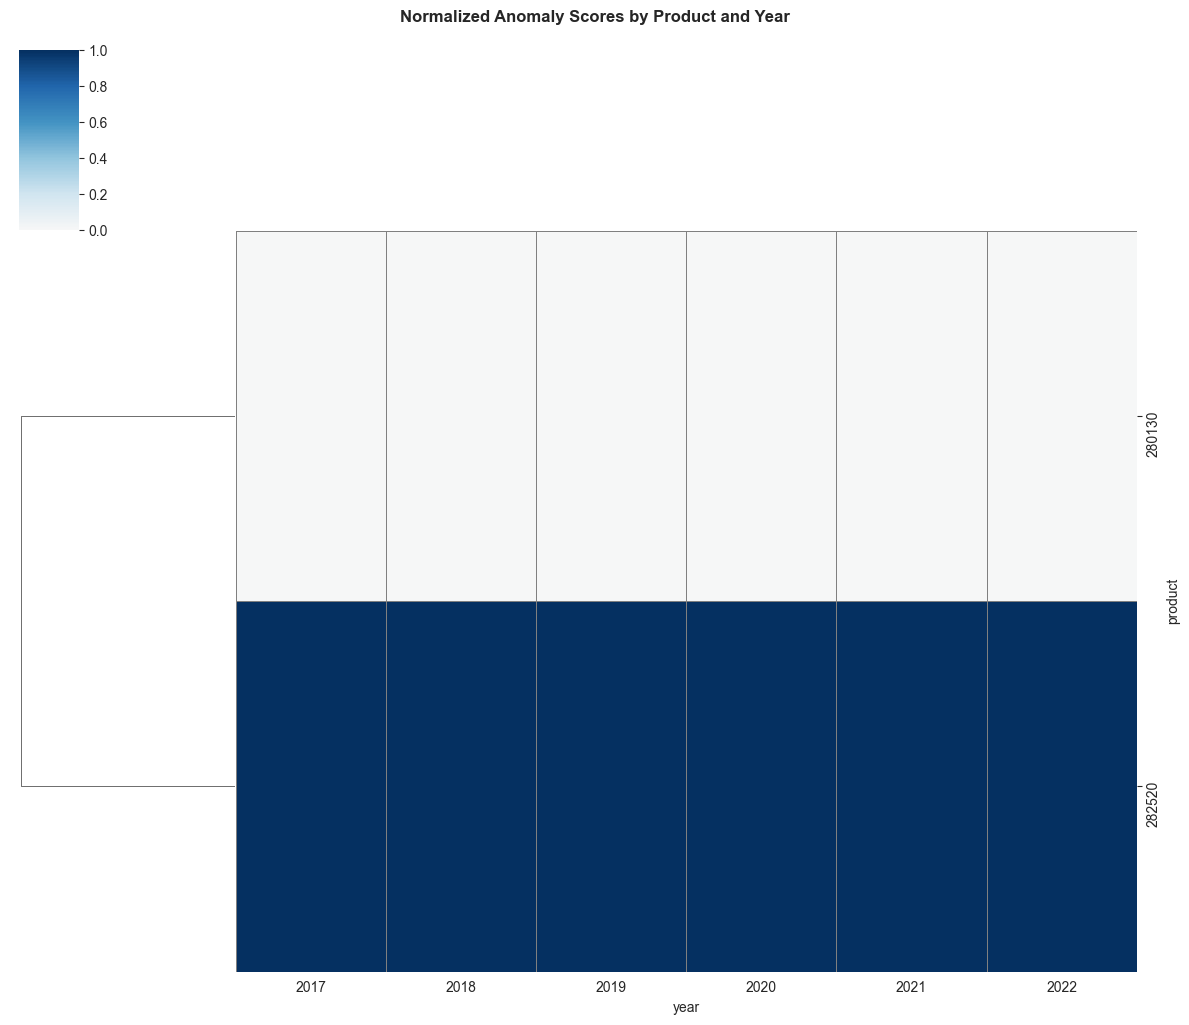

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df.sort_values(by=["year"], ascending=[True], inplace=True)

pivot_df = results_df.pivot(
    index="product",
    columns="year",
    values="normalized_anomaly_score"
)

g = sns.clustermap(
    pivot_df, 
    cmap="RdBu",
    center=0,         
    metric="euclidean",
    method="average",
    standard_scale=1, 
    linewidths=0.5, 
    linecolor='gray', 
    figsize=(12, 10),
    col_cluster=False
)

plt.suptitle("Normalized Anomaly Scores by Product and Year", y=1.02, fontweight="bold")
output_path = "graphics/clustermap.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

In [6]:
results_df.sort_values(by="normalized_anomaly_score", ascending=False)

,product,year,Unnamed: 0,anomaly_score,normalized_anomaly_score,num_edges
371,282520,2022,150.0,187.730990,4.868543,631.0
846,440729,2017,1046.0,49.409870,1.957534,2455.0
1093,710900,2018,1246.0,31.481358,1.232855,584.0
317,271600,2022,546.0,9.717204,1.193504,452.0
448,290541,2021,695.0,6.772557,1.041737,457.0
...,...,...,...,...,...,...
1565,854091,2022,6.0,0.043703,-0.065336,443.0
1383,810830,2020,1503.0,0.256966,-0.066844,491.0
1384,810830,2021,1505.0,0.257609,-0.067348,536.0
245,262029,2022,528.0,0.133728,-0.084826,237.0


In [7]:
from joblib import Parallel, delayed

###################################################
# Parallelized Product-Year Loop (still super slow)
# + constantly leading to memory overflow
###################################################
all_years = df.select(pl.col("t")).unique().to_series().to_list()
all_products = df.select(pl.col("k")).unique().to_series().to_list()

############################################
# MANUAL OVERWRITE TO SAVE COMPUTE
start_year = 2017

all_products = [
    
    ##########################
    # Anomalous Candidates
    ##########################
    854060,  # Tubes: cathode ray
    854091,  # Parts of cathode-ray tubes
    854129,  # Transistors (dissipation 1W or more)
    854121,  # Transistors (dissipation <1W)
    854130,  # Thyristors, diacs, triacs
    854071,  # Tubes: microwave, magnetrons
    852313,  # Flat panel display modules
    852390,  # Parts for apparatus of heading 8524 to 8528
    853720,  # Boards, panels, consoles for electricity distribution
    853530,  # Isolating & make-and-break switches (>1000 volts)
    846130,  # Machine-tools: broaching machines
    902710,  # Instruments for gas or smoke analysis
    841950,  # Heat exchange units
    847930,  # Machinery for treating wood/cork
    901210,  # Microscopes
    848240,  # Needle roller bearings
    848280,  # Other bearings
    902780,  # Instruments for measuring variables of liquids or gases
    853210,  # Electrical capacitors: power capacitors
    841229,  # Hydraulic power engines and motors
    750110,  # Nickel mattes
    720827,  # Iron or non-alloy steel, hot-rolled
    721931,  # Steel, stainless: flat-rolled
    750711,  # Nickel: tubes and pipes
    722840,  # Steel, alloy: bars and rods
    282520,  # Lithium oxide and hydroxide
    400249,  # Rubber: synthetic chloroprene
    291613,  # Methacrylic acid
    291823,  # Carboxylic acids (complex), raw materials for pharmaceuticals/chemicals
    292146,  # Amine-function compounds (complex intermediates)
    270900,  # Crude petroleum oils
    271113,  # Butanes, liquefied
    271114,  # Liquefied ethylene, propylene, etc.
    271129,  # Petroleum gases, gaseous state
    271210,  # Petroleum jelly
    271320,  # Petroleum bitumen
    270111,  # Anthracite coal
    270112,  # Bituminous coal
    282710,  # Ammonium chloride
    750400,  # Nickel powders and flakes
    294190,  # Vacinations
    760110,  # Aluminium
    853400,  # Semiconductors
    
    ##########################
    # Baseline Candidates
    ##########################
    250100,  # Salt
    170199,  # Sugars: sucrose, chemically pure
    100610,  # Cereals: rice in the husk (paddy)
    110100,  # Wheat or meslin flour
    40210,   # Milk and cream, concentrated or sweetened
    120300,  # Copra
    230250,  # Bran, sharps and residues of leguminous plants
    190220,  # Stuffed pasta, unprepared
    200799,  # Jams, fruit jellies and marmalades (other fruits)
    80450,   # Fruit: guavas, mangoes and mangosteens, fresh or dried
    300490,  # Medicine: Antibiotics
]
############################################

evaluation_years = [y for y in all_years if y >= start_year]

tasks = [(product, year) for product in all_products for year in evaluation_years]

parallel_results = Parallel(n_jobs=4, backend="loky")(
    delayed(run_for_product_year)(df, product, year, edge_feature_cols, n_folds=1, device=device)
    for product, year in tasks
)

rows = []
for (product, year), res in zip(tasks, parallel_results):
    if res != (None, None, None):
        target_mean_score, z_score, num_edges = res
        rows.append({
            "product": product,
            "year": year,
            "anomaly_score": target_mean_score,
            "normalized_anomaly_score": z_score,
            "num_edges": num_edges
        })

results_df = pd.DataFrame(rows)

NameError: name 'df' is not defined